In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [2]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [3]:
data = pd.read_csv('train.csv')
data

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490
...,...,...
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958


In [4]:
data_train = read_set('train.csv')
data_test =  read_set('derived.csv')
data_sample = read_set('sample_submission.csv')

In [5]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


### Проверим наши данные, что мы загрузили

In [6]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [7]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [8]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [9]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

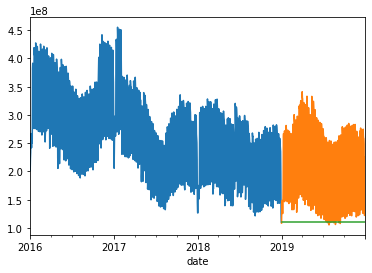

In [10]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [11]:
# обучаем модель
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.69 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=0.73 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=1.78 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=2.95 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.126, Time=3.14 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=6.16 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=6.51 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=4.72 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=3.91 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.292, Time=10.80 sec
 ARIMA(2,0,3)(2,0,

In [12]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [13]:
prediction

,0
date,
2019-01-01,2.192316e+08
2019-01-02,2.716804e+08
2019-01-03,2.327291e+08
2019-01-04,1.703579e+08
2019-01-05,2.181284e+08
...,...
2019-12-27,2.748540e+08
2019-12-28,2.738288e+08
2019-12-29,2.732848e+08


In [14]:
prediction = prediction .rename(columns = {0:'value'})

смотрим, что она нам предсказала

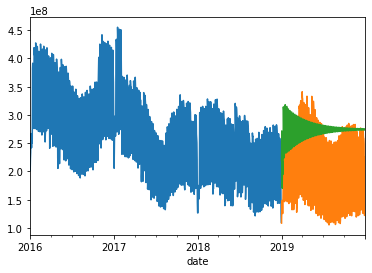

In [15]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

### Функция подсчета метрик для конкурса

In [16]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [17]:
MAPE(data_test, prediction)

38.890305153608985

In [18]:
MAPE(data_test, data_sample)

44.81735178659308

## Из пандас строим датасет

In [19]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

In [829]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1 # Кол-во проходов заданным окном
        self.mean = stats.mean 
        self.std = stats.std
        self.data = (data- self.mean) / self.std # Нормализация
        self.seq_len = seq_len # Длина окна
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len] # Берем последовательность датафрейма
        targets = []
        days   = []
        months = []
        year = []
        weekday = []
        for row in  d.iterrows(): # итератор по строкам dataframe
            targets += [ row[1]['value'] ] # Получить value из строки
            days += [ row[0].day ] # 
            months += [row[0].month]
            year += [row[0].year]
            weekday += [row[0].weekday()]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(weekday), \
               torch.FloatTensor(targets)

In [830]:
ds_train = TSDataset(data_train, 20) 
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))


1077


## Теперь нужно определить нашу модель 

In [831]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(777)

In [832]:
import datetime
ans = datetime.date(2022, 1, 4)
ans.weekday()

1

In [1502]:
class TimeSeriesModel(nn.Module):
    def __init__(self, hidden_size: int, input_sizes: tuple):
        super().__init__()
        self.mon_emb = nn.Embedding(12+1, input_sizes[0]) # Эмбеддинги для месяцев (обучаемые)
        self.day_emb = nn.Embedding(31+1, input_sizes[1]) # Эмбеддинги для годов (обучаемые)
        self.weekday_emb = nn.Embedding(7, input_sizes[2])
        self.weekend_emb = nn.Embedding(7, input_sizes[3])
        
        # LSTM input: Эмбеддинги годов, месяцев, значение                      
        self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1] + input_sizes[2] + input_sizes[3] + 1,
                            hidden_size,  batch_first=True, dropout=0.3)
        self._output = nn.Linear(hidden_size, 1)

    def forward(self, batch, ctx = None):
        days, mons, weekday, targets = batch
        mon_tensor = self.mon_emb(mons) # batch_sz x seq_len x emb_len (8 x 20 x 4)
        day_tensor = self.day_emb(days)
        weekday_tensor = self.weekday_emb(weekday)
        weekend = ((weekday == 5) | (weekday == 6))
        weekend_tensor = self.weekend_emb(weekend.long())
        rnn_input  = torch.cat([mon_tensor, day_tensor, weekday_tensor, weekend_tensor], dim=-1) # 8 x 20 x 8
        targets = targets.unsqueeze(-1)
        rnn_input = torch.cat([rnn_input, targets ], dim=-1) # 8 x 20 x 9
        # Берем все элементы последовательности, кроме последнего, предсказание идет на 1 шаг вперед
        rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input # 8 x 19 x 9
        output, ctx = self._rnn(rnn_input, ctx)
        # 8 x 19 x 32, 1 x 8 x 32
        # print((self._output(output)).size()) 8 x 19 x 1
        output = self._output(output).squeeze() # 8 x 19 
        return output, ctx        

### Определяем даталоадеры для теста и трейна

In [1523]:
batch_sz = 8
hidden_size = 32
emb_size = (3, 4, 2, 1)

dl_train = DataLoader(ds_train, batch_sz , True)
dl_test = DataLoader(ds_test, batch_sz , False)
series_model = TimeSeriesModel(hidden_size, emb_size)

/home/fedor/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [1524]:
from torch.optim.lr_scheduler import ExponentialLR

In [1525]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=7e-4)# lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.97)

In [1526]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./rnn_hw')

In [1527]:
0.97 ** 20

0.543794342926747

### Обучаем модель

In [1528]:
global_epoch = 0
global_iter = 0

In [1529]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    print("Test:", sum_loss.item(), epoch)
    return sum_loss

In [1530]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс

for epoch in range(0, 25):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        #print(batch[0].size())
        # batch.size() : 4 (day, month, year, target) x batch_sz x seg_len
        #import sys
        #sys.exit()
        target = batch[-1][:,1:] # Берем все значения, начиная  с 1
        result, hidden = series_model(batch)
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 112.94it/s]


Test: 0.6462616324424744 0


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 115.45it/s]


Test: 0.3712575137615204 1


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 110.26it/s]


Test: 0.24297839403152466 2


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 117.43it/s]


Test: 0.2128915637731552 3


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 109.27it/s]


Test: 0.2019299417734146 4


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 114.37it/s]


Test: 0.19237397611141205 5


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 117.47it/s]


Test: 0.1896532028913498 6


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 118.96it/s]


Test: 0.18530568480491638 7


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 118.76it/s]


Test: 0.1799982786178589 8


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 115.62it/s]


Test: 0.17865577340126038 9


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 117.45it/s]


Test: 0.17648911476135254 10


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 117.15it/s]


Test: 0.17664435505867004 11


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 118.35it/s]


Test: 0.1742175817489624 12


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 119.87it/s]


Test: 0.1735067516565323 13


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 103.00it/s]


Test: 0.17588815093040466 14


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 101.63it/s]


Test: 0.17371903359889984 15


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 103.17it/s]


Test: 0.17361126840114594 16


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 104.04it/s]


Test: 0.17474637925624847 17


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 102.05it/s]


Test: 0.17267434298992157 18


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 100.56it/s]


Test: 0.17403249442577362 19


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 100.91it/s]


Test: 0.17481407523155212 20


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 104.79it/s]


Test: 0.17382477223873138 21


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 102.48it/s]


Test: 0.17455996572971344 22


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 103.21it/s]


Test: 0.17378662526607513 23


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 105.01it/s]

Test: 0.17505021393299103 24


In [1531]:
# сохраняем модель
torch.save(series_model.state_dict(), 'series_model2.ptx')

In [1532]:
# восстанавливаем модель
series_model = TimeSeriesModel(hidden_size, emb_size)
series_model.load_state_dict(torch.load('series_model2.ptx'))

/home/fedor/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [1533]:
#!tensorboard --logdir=rnn_hw

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

In [1534]:
# новые даталоадеры НЕ перемешанные
new_ds_train = TSDataset(data_train, 1) 
new_ds_test  = TSDataset(data_test, 1)
new_dl_train = DataLoader(new_ds_train, 1 , False)
new_dl_test = DataLoader(new_ds_test, 1, False)

In [1535]:
# Уже с предобученной моделью - посчитаем h, c за все предыдущие года
h = torch.zeros(1, 1, hidden_size)
c = torch.zeros(1, 1, hidden_size)
hidden = (h, c)
ole = []
with torch.no_grad():
    series_model.eval()
    for batch in new_dl_train:
        result, hidden = series_model(batch, hidden) # Накапливаем память о последовательности
        ole.append(result.item())
last_res = result
results = []

with torch.no_grad():
    series_model.eval()
    for batch in new_dl_test:
        batch[3][0] = last_res
        results.append(last_res.item())
        last_res, hidden = series_model(batch, hidden)
results = np.array(results)

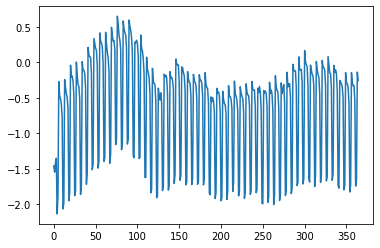

In [1536]:
plt.plot(results)

In [1537]:
results = results * stats.std.value + stats.mean.value

In [1538]:
prediction = pd.DataFrame(results, data_test.index)
prediction = prediction.rename(columns = {0:'value'})

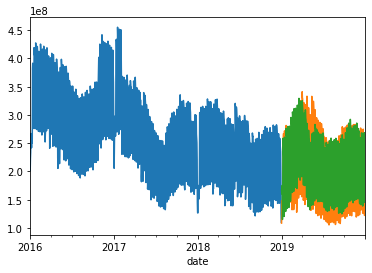

In [1539]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot()
plt.show()

In [1540]:
MAPE(data_test, prediction)

10.39724253517867

In [1541]:
MAPE(data_test, prediction)

10.39724253517867

In [1542]:
prediction = prediction.rename(columns = {"value" :'hits'})
prediction

,hits
date,
2019-01-01,1.670498e+08
2019-01-02,1.604147e+08
2019-01-03,1.707073e+08
2019-01-04,1.754112e+08
2019-01-05,1.151366e+08
...,...
2019-12-27,2.386314e+08
2019-12-28,1.452579e+08
2019-12-29,1.514651e+08


In [1543]:
prediction.to_csv("submission.csv")